In [1]:
import argparse
import os
import sys

# ##### REMEMBER TO MANUALLY COPY THE PROXY TO YOUR CERNBOX FOLDER AND TO MODIFY THE NEXT LINE
# os.environ['X509_USER_PROXY'] = '{}/tmp/x509up_u15148'.format(os.environ["HOME"])
# if os.path.isfile(os.environ['X509_USER_PROXY']): 
#     print("Found proxy at {}".format(os.environ['X509_USER_PROXY']))
# else: 
#     print("Failed to find proxy at {}".format(os.environ['X509_USER_PROXY']))
# os.environ['X509_CERT_DIR'] = '/cvmfs/cms.cern.ch/grid/etc/grid-security/certificates'
# os.environ['X509_VOMS_DIR'] = '/cvmfs/cms.cern.ch/grid/etc/grid-security/vomsdir'

In [2]:
import awkward1 as ak
from coffea import processor, hist
from coffea.analysis_objects import JaggedCandidateArray
import numpy as np

In [4]:
class Analyzer(processor.ProcessorABC):
    
    def __init__(self, ismc, year):
        self.ismc = ismc
        self.year = year
        self.baseTriggers = {
            '2016' : [ 'IsoMu24', 'IsoTkMu24'],
            '2017' : [ 'IsoMu27' ],
            '2018' : [ 'IsoMu24' ],
        }
        self.triggers = [ 'AK8PFJet140','AK8PFJet200', 'AK8PFJet260', 'AK8PFJet320', 'AK8PFJet400', 'AK8PFJet450', 'AK8PFJet500']
                    
        self._columns = [ 'FatJet_pt', 'FatJet_eta', 'FatJet_msoftdrop', 'FatJet_jetID' ] + [ 'HLT_'+t for t in self.triggers ]
        self._accumulator = processor.dict_accumulator({
            "sumw": processor.defaultdict_accumulator(float),
            
            "jets": hist.Hist(
                "entries",
                hist.Cat("dataset", "Dataset"),
                hist.Cat("selection", "Selection"),
                hist.Bin("pt", r"Leading jet $p^{T}$ [GeV]", 100, 0, 1000),
                hist.Bin("eta", r"Leading jet $\eta$", 10, -5, 5),
                hist.Bin("mass", r"Leading jet softdrop mass [GeV]", 51, 0, 500),
            ),
            'cutflow': hist.Hist(
                'entries',
                hist.Cat('dataset', 'Dataset'),
                hist.Bin('cut', 'Cut index', 11, 0, 11),
            ),

        })

    @property
    def accumulator(self):
        return self._accumulator
    
    @property
    def columns(self):
        return self._columns
    

    def process(self, events): #, parameters=parameters, samples_info={}, \
                #lumimask=None, cat=False, boosted=False, uncertainty=None, \
                #uncertaintyName=None, parametersName=None, extraCorrection=None):

        dataset = events.metadata['dataset']
        isRealData = 'genWeight' not in events.columns
        selection = processor.PackedSelection()
        weights = processor.Weights(len(events))
        output = self.accumulator.identity()
        
        nEvents = events.size
        run = events.run
        luminosityBlock = events.luminosityBlock
        #print("Processing %d %s events" % (nEvents, dataset))

        basetrigger = np.zeros(events.size, dtype='bool')
        for t in self.baseTriggers[self.year]: basetrigger = basetrigger | events.HLT[t]
        selection.add('basetrigger', basetrigger)
        
        dummyTriggerDict = {}
        for it in self.triggers:
            dummyTriggerDict[ it ] = np.zeros(events.size, dtype='bool')
            dummyTriggerDict[ it ] = dummyTriggerDict[ it ] | events.HLT[it]
            selection.add('trigger'+it, dummyTriggerDict[ it ])

        fatjets = events.FatJet
        candidatejet = fatjets[
            (fatjets.pt > 200)
            & (abs(fatjets.eta) < 2.5)
            & fatjets.isTight  # this is loose in sampleContainer
        ]
        candidatejet = candidatejet[:, 0:1]
        selection.add( 'njetsBasic', ( 
            (candidatejet.pt >= 200)
            & (candidatejet.msoftdrop >= 40.)
            & (abs(candidatejet.eta) < 2.5)
        ).any() ) 
        
        baseCuts = [ 'njetsBasic', 'basetrigger'  ] 
        triggerCuts = [ 'trigger'+i for i in self.triggers ]
        
#         allcuts = set()
#         #output['cutflow'].fill(dataset=dataset, cut=0 )
#         for i, cut in enumerate(cuts):
#             allcuts.add(cut)
#             cut = selection.all(*allcuts)
#             output['cutflow'].fill(dataset=dataset, cut=i)

        
        def normalize(val, cut):
            return val[cut].pad(1, clip=True).fillna(0).flatten()

        allcuts = set()
        for icut in baseCuts:
            allcuts.add(icut)
            jcut = selection.all(*allcuts)
            output['jets'].fill(
                dataset=dataset,
                selection=icut,
                pt=normalize(candidatejet.pt, jcut), 
                eta=normalize(candidatejet.eta, jcut), 
                mass=normalize(candidatejet.msoftdrop, jcut),
#                 weight=weight,
            )
        
        
        
        for icut in triggerCuts:
            allcuts = set(baseCuts)
            allcuts.add(icut)
            jcut = selection.all(*allcuts)
            output['jets'].fill(
                dataset=dataset,
                selection=icut,
                pt=normalize(candidatejet.pt, jcut), 
                eta=normalize(candidatejet.eta, jcut), 
                mass=normalize(candidatejet.msoftdrop, jcut),
#                 weight=weight,
            )
        
        return output

    def postprocess(self, accumulator):
        return accumulator


In [5]:
samples = {
        'SingleMuon2017B': [
            "root://xrootd-cms.infn.it//store/data/Run2017B/SingleMuon/NANOAOD/UL2017_02Dec2019-v1/70000/BEFC25BC-02AE-724B-A0C8-E0F6F2CD97E4.root",
            "root://xrootd-cms.infn.it//store/data/Run2017B/SingleMuon/NANOAOD/UL2017_02Dec2019-v1/70000/FC54AA3D-F3E3-8E47-904D-A1CF57776A03.root",
            "root://xrootd-cms.infn.it//store/data/Run2017B/SingleMuon/NANOAOD/UL2017_02Dec2019-v1/70000/6328267C-BB6E-C74C-B0C4-FBDBA11A4A51.root",
            "root://xrootd-cms.infn.it//store/data/Run2017B/SingleMuon/NANOAOD/UL2017_02Dec2019-v1/70000/A0D5A4D0-4D31-5E41-9372-6E456DD5359D.root",
            "root://xrootd-cms.infn.it//store/data/Run2017B/SingleMuon/NANOAOD/UL2017_02Dec2019-v1/70000/F36842AE-0E88-384F-AB7D-F81304A5E7F6.root",
            "root://xrootd-cms.infn.it//store/data/Run2017B/SingleMuon/NANOAOD/UL2017_02Dec2019-v1/70000/BEFC25BC-02AE-724B-A0C8-E0F6F2CD97E4.root"
        ],
#         'tt semileptonic': [
#             "root://xrootd-cms.infn.it//store/user/algomez/tmpFiles/ttH/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/TTToSemiLeptonic_nanoAODPostProcessor_2017_v03/200903_113849/0000/nano_postprocessed_97.root"
#         ]
}

print("Running uproot job...")
result = processor.run_uproot_job(
        samples,
        "Events",
        Analyzer(ismc=False,year='2017'),
        processor.futures_executor,
        {"nano": True, "workers": 30},
        chunksize=100000,
        maxchunks=1000,
)



Running uproot job...


In [3]:
import matplotlib.pyplot as plt
import mplhep as hep
%matplotlib inline
# plt.style.use(hep.style.ROOT)
hep.set_style("CMS")

In [10]:
from coffea.util import load
from coffea.hist import plot

result = load('hists_None_trigger_sample_test.coffea')
print(result)

{'sumw': defaultdict_accumulator(<class 'float'>, {}), 'jets': <Hist (dataset,selection,pt,eta,mass) instance at 0x7fc82a307510>, 'cutflow': <Hist (dataset,cut) instance at 0x7fc82a4d6e10>}


ValueError: Plotting multiple histograms with different binning is not supported

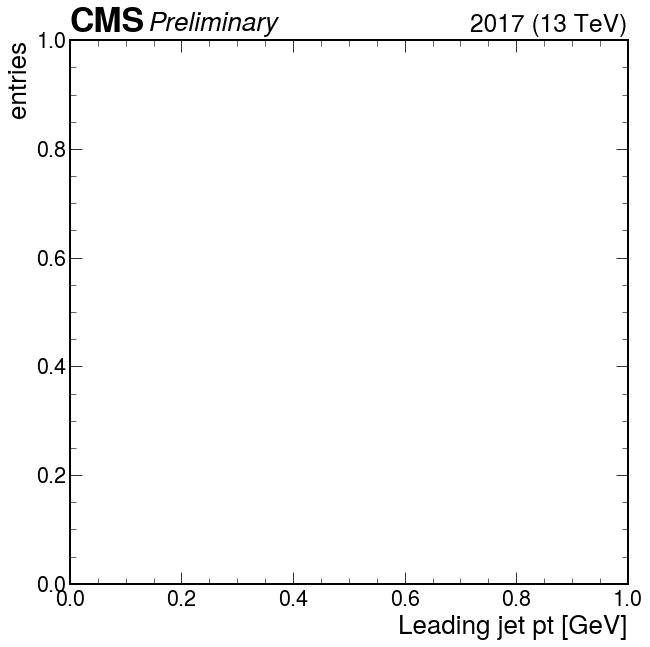

In [8]:
hep.cms.label(data=True,year='2017')
tmpHist = result['jets'].integrate('dataset').sum('eta','mass').rebin("pt", hist.Bin("newpt", "Leading jet pt [GeV]", 45, 100, 1000))
a = hist.plot1d(tmpHist)
a.set_ylim(0,100)
# a.set_xlim(100,800)


In [ ]:
newBin = hist.Bin("newpt", "Leading jet pt [GeV]", 20, 100, 900)
denominator = result['jets'].integrate('dataset').integrate('selection', ['basetrigger']).sum('eta','mass').rebin('pt', newBin)
numerator = result['jets'].integrate('dataset').integrate('selection', ['triggerAK8PFJet450']).sum('eta','mass').rebin('pt', newBin)

ax = hist.plotratio(
    num=numerator,
    denom=denominator,
    error_opts={'color': 'k', 'marker': '.'},
#     unc='num'
)
ax.set_ylim(-0.1,1.1)
# ax.set_xlim(100,1000)

In [ ]:
################## DOES NOT WORK


#### Translate to root
import ROOT
%jsroot

canvas = {} ### needed to plot several histos in a loop

histDict = {}
for ih in tmpHist.identifiers('selection'):
    histDict[ih.name] = hist.export1d(tmpHist.integrate('selection', ih))
    print(ih)
print(histDict)

In [ ]:

tLabel = 'triggerAK8PFJet500'

denominator = histDict['basetrigger'].Clone()
numerator = histDict[tLabel].Clone()

canvas[tLabel] = ROOT.TCanvas( tLabel, tLabel, 500, 700)
denominator.Draw('histe')
numerator.Draw('histe same')
canvas[tLabel].Draw()


In [ ]:
hep.cms.label(data=True,year='2017')

a = hist.plot1d(result['cutflow'] ) #, overlay='dataset')

In [ ]:
import pyspark.sql
from pyarrow.compat import guid
from coffea.processor.spark.detail import _spark_initialize, _spark_stop
from coffea.processor.spark.spark_executor import spark_executor

partitionsize = 200000
thread_workers = 10

fileset = {
    'SingleMuon2017B': {
        'files': [
            "root://xrootd-cms.infn.it//store/data/Run2017B/SingleMuon/NANOAOD/UL2017_02Dec2019-v1/70000/BEFC25BC-02AE-724B-A0C8-E0F6F2CD97E4.root",
            "root://xrootd-cms.infn.it//store/data/Run2017B/SingleMuon/NANOAOD/UL2017_02Dec2019-v1/70000/FC54AA3D-F3E3-8E47-904D-A1CF57776A03.root",
            "root://xrootd-cms.infn.it//store/data/Run2017B/SingleMuon/NANOAOD/UL2017_02Dec2019-v1/70000/6328267C-BB6E-C74C-B0C4-FBDBA11A4A51.root",
            "root://xrootd-cms.infn.it//store/data/Run2017B/SingleMuon/NANOAOD/UL2017_02Dec2019-v1/70000/A0D5A4D0-4D31-5E41-9372-6E456DD5359D.root",
            "root://xrootd-cms.infn.it//store/data/Run2017B/SingleMuon/NANOAOD/UL2017_02Dec2019-v1/70000/F36842AE-0E88-384F-AB7D-F81304A5E7F6.root",
            "root://xrootd-cms.infn.it//store/data/Run2017B/SingleMuon/NANOAOD/UL2017_02Dec2019-v1/70000/BEFC25BC-02AE-724B-A0C8-E0F6F2CD97E4.root"
        ],
        'treename' : 'Events'
    }
#         'tt semileptonic': [
#             "root://xrootd-cms.infn.it//store/user/algomez/tmpFiles/ttH/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/TTToSemiLeptonic_nanoAODPostProcessor_2017_v03/200903_113849/0000/nano_postprocessed_97.root"
#         ]
}


output = processor.run_spark_job(fileset, Analyzer(ismc=False,year='2017'), spark_executor, 
                                 spark=spark, partitionsize=partitionsize, thread_workers=thread_workers,
                                 #executor_args={'file_type': 'edu.vanderbilt.accre.laurelin.Root', 'cache': False}
                                )


print(output)